In [103]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pdf2image
import easyocr
import pandas as pd
%matplotlib inline 


11599101


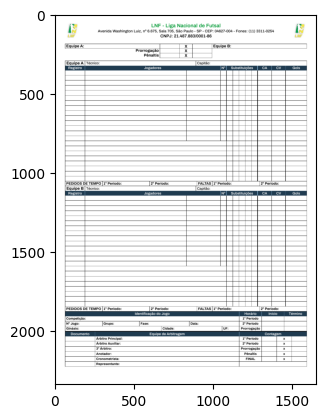

In [104]:
basepdf_path = 'images/input/BASE-LNF.pdf'
images = pdf2image.convert_from_path(basepdf_path)
base=np.array(images[0])
plt.imshow(base)
print(base.size)


11599101


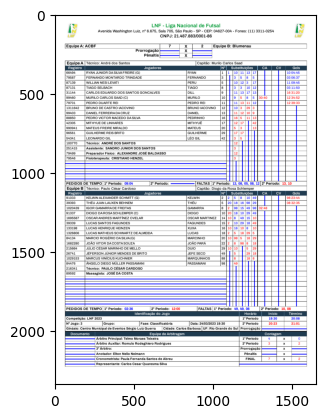

In [105]:
sum_path = 'images/input/Sumula1-LNF.pdf'
images = pdf2image.convert_from_path(sum_path)
sumula=np.array(images[0])
print (sumula.size)
plt.imshow(sumula)

True

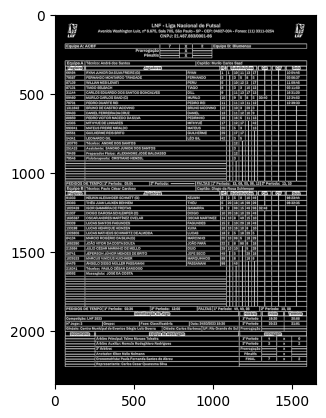

In [106]:
#Test preprocessing the images b4 OCR
def preprocess(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5,5), 0)
    thresh = cv.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return thresh

base_preprocessed = preprocess(base)
sumula_preprocessed = preprocess(sumula)

plt.imshow(base_preprocessed,cmap='gray')
cv.imwrite('images/base_preprocessed.png',base_preprocessed)
plt.imshow(sumula_preprocessed,cmap='gray')
cv.imwrite('images/sumula_preprocessed.png',sumula_preprocessed)


In [107]:
base_gray = cv.cvtColor(base, cv.COLOR_BGR2GRAY)
sumula_gray = cv.cvtColor(sumula, cv.COLOR_BGR2GRAY)

# Usar ORB para detectar e computar as características
orb = cv.ORB_create(50000)

keypoints1, descriptors1 = orb.detectAndCompute(sumula_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(base_gray, None)

# Usar BFMatcher para encontrar correspondências
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Ordenar as correspondências pela distância (qualidade)
matches = sorted(matches, key=lambda x: x.distance)

# Selecionar um número razoável de melhores correspondências para calcular a homografia
good_matches = matches[:500]

# Obter os pontos das correspondências
points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Calcular a homografia usando RANSAC para maior robustez
h, mask = cv.findHomography(points2, points1, cv.RANSAC)

# Aplicar a homografia para alinhar a segunda imagem com a primeira
height, width = sumula_gray.shape
aligned_image2 = cv.warpPerspective(base_gray, h, (width, height))

# Subtrair as imagens alinhadas
subtracted_image = cv.absdiff(sumula_gray, aligned_image2)

# Salvar ou mostrar a imagem subtraída
cv.imwrite('images/test_ORB.jpg', subtracted_image)


True

True

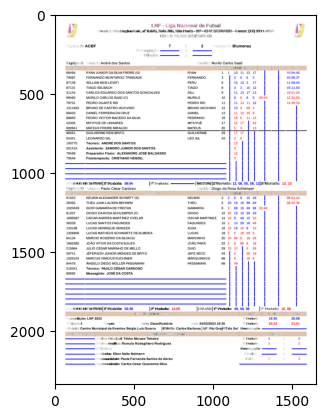

In [108]:
mask = cv.threshold(base_gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
mask = cv.bitwise_not(mask)
result_ops = cv.bitwise_not(sumula, sumula, mask=mask)
plt.imshow(result_ops,cmap='gray')
cv.imwrite('images/bitnot.jpg', result_ops)

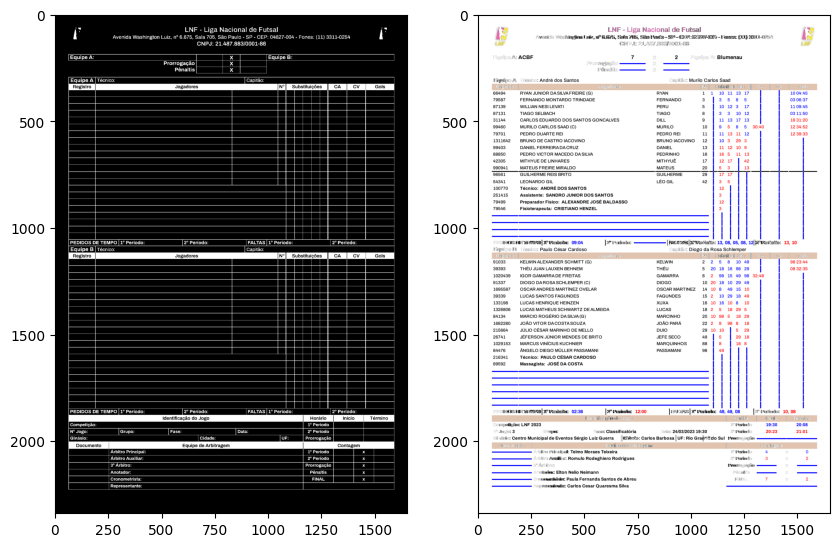

In [109]:
#plot the mask and the result in the same figure
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(mask, cmap='gray')
ax[1].imshow(result_ops, cmap='gray')
plt.show()

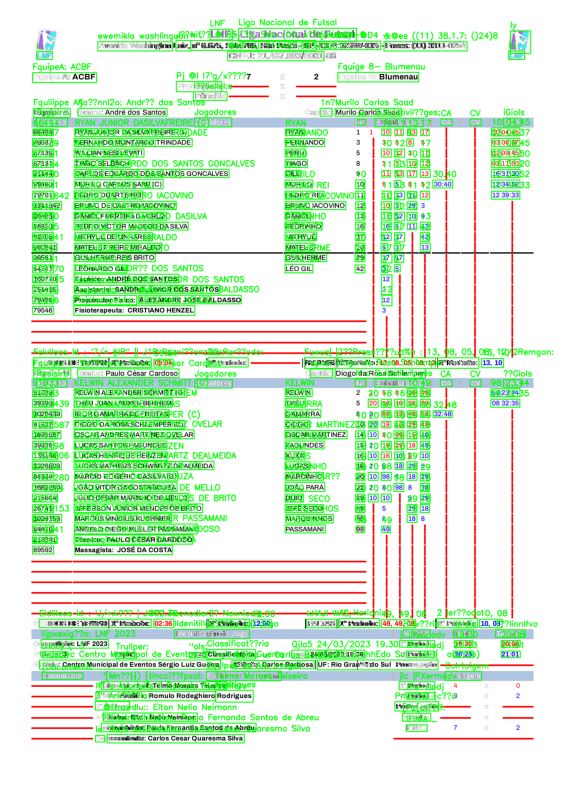

True

In [110]:
reader = easyocr.Reader(['pt'])
results = reader.readtext(result_ops)

# Draw bounding boxes and text on the image
for (bbox, text, prob) in results:
    # Extract the bounding box coordinates
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple([int(x) for x in top_left])
    bottom_right = tuple([int(x) for x in bottom_right])

    # Draw the bounding box on the image
    cv.rectangle(result_ops, top_left, bottom_right, (0, 255, 0), 2)

    # Display the detected text
    cv.putText(result_ops, text, (top_left[0], top_left[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR to RGB for matplotlib display
img_rgb = cv.cvtColor(result_ops, cv.COLOR_BGR2RGB)

# Display the image with bounding boxes and text
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()
cv.imwrite('images/ocr.jpg', img_rgb)


In [111]:
#store the ocr results in a csv file
df = pd.DataFrame(results, columns=['bbox', 'text', 'confidence'])
df.to_csv('images/ocr_results.csv', index=False)



